##Our Task is to find whether pokemon exist in image or not from 3 different pokemon, if exist the find coordinates against real different backgrounds, pokemon has been resized by some scale and can be horizontally flipped too

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.applications import VGG16

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip
!unzip -n backgrounds.zip

File ‘charmander-tight.png’ already there; not retrieving.

File ‘bulbasaur-tight.png’ already there; not retrieving.

File ‘squirtle-tight.png’ already there; not retrieving.

File ‘backgrounds.zip’ already there; not retrieving.

Archive:  backgrounds.zip


In [4]:
from imageio import imread
obj1 = imread('charmander-tight.png')
obj2 = imread('bulbasaur-tight.png')
obj3 = imread('squirtle-tight.png')
obj = ["", obj1, obj2, obj3]
print(obj1.shape, obj2.shape, obj3.shape)

(56, 44, 4) (48, 43, 4) (54, 44, 4)


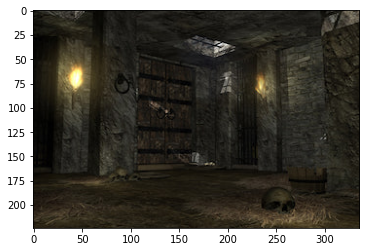

In [5]:
from glob import glob
backgrounds = []
bg_files = glob('backgrounds/*.jpg')
for bg_path in bg_files:
    bg = imread(bg_path)
    backgrounds.append(bg)

plt.imshow(backgrounds[2])

In [6]:
#Created and loaded model with input image of size (200,200,3) 
dim = 200 #pixels in image
image_size = (dim,dim,3)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_size)
x = Flatten()(vgg.output)
x1 = Dense(4, activation='sigmoid')(x) #4 node for coordinates of bounding box
x2 = Dense(3, activation='softmax')(x) #3 node for detecting class of object
x3 = Dense(1, activation='sigmoid')(x) #1 node for does any object is present or not
x = Concatenate()([x1,x2,x3])
model = tf.keras.Model(inputs=vgg.input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [7]:
obj[1].shape

(56, 44, 4)

In [8]:
def get_image():
    x = np.zeros(image_size, dtype=float)  #image pixel value
    y = np.zeros(8, dtype=float)  #top-left coordinate and height and width, (row,col,height,width,isexist) within range [0,1)
    
    #Choosing random part of background of size (dim,dim,3) from list of backgrounds
    bg_id = np.random.randint(0,len(backgrounds))
    bg_h, bg_w, _ = backgrounds[bg_id].shape
    bg_r = np.random.randint(0,bg_h-dim)
    bg_c = np.random.randint(0,bg_w-dim)
    x = backgrounds[bg_id][bg_r:bg_r+dim,bg_c:bg_c+dim,:].copy()  #Assigning a slice of background, all features since it is jpg

    obj_class = np.random.randint(0,4)
    if obj_class>0:
        obj_h, obj_w, _ = obj[obj_class].shape
        y[3+obj_class], y[7] = 1, 1

        #resizing the object randomly in scale of range (0.5,1.5)
        scale = 0.5+ np.random.random()
        new_h, new_w = round(scale*obj_h), round(scale*obj_w)
        char = resize(obj[obj_class], (new_h,new_w), preserve_range=True).astype(np.uint8)

        #flipping the object randomly
        if np.random.random() < 0.5:
            char = np.fliplr(char)

        row0 = np.random.randint(0, dim-new_h)
        col0 = np.random.randint(0, dim-new_w)
        slice = x[row0:row0+new_h, col0:col0+new_w,:] #slicing the box where pokemon will be placed
        mask = (char[:,:,3]==0)  #assigning value 0 where pokemon pixel exist else 1
        slice = slice*np.expand_dims(mask,-1) #filtering box and choosing background where pokemon pixel doesn't exist
        slice = slice + char[:,:,:3]  #adding pokemon pixel at empty place
        x[row0:row0+new_h, col0:col0+new_w,:] = slice #assigning slice of image to resized pokemon
        y[0], y[1], y[2], y[3] = row0, col0, new_h, new_w
        y[0:4] = y[0:4]/dim
    return x, y

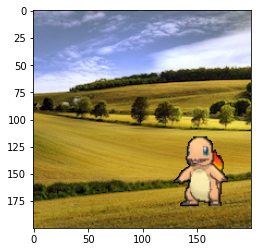

In [9]:
x,y = get_image()
plt.imshow(x/255.)

In [10]:
num_batches = 50
batch_size = 64
def my_generator():
    while True:
        for _ in range(num_batches):
            X = np.zeros((batch_size,) + image_size, dtype=float)
            Y = np.zeros((batch_size, 8), dtype=float)
            for i in range(batch_size):
                X[i],Y[i] = get_image()
            yield X/255.,Y

In [11]:
#loss is defined alpha*y_true[7]*bce_point + gamma*y_true[7]*cce_class + beta*bce_exist
def custom_loss(y_true, y_pred):
    #tuple of 8 points
    #(row, col, height, width, class_a, class_b, class_c, is_exist)
    bce_point = binary_crossentropy(y_true[:,0:4], y_pred[:,0:4])
    cce_class = categorical_crossentropy(y_true[:,4:7], y_pred[:,4:7])
    bce_exist = binary_crossentropy(y_true[:,7], y_pred[:,7])
    return y_true[:,7]*bce_point + y_true[:,7]*cce_class + 0.5*bce_exist

In [12]:
model.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics='mse')
model.fit(my_generator(), epochs=10, steps_per_epoch=num_batches)

Epoch 1/10
50/50 [==============================] - 52s 758ms/step - loss: 0.7543 - mse: 0.0594
Epoch 2/10
50/50 [==============================] - 37s 735ms/step - loss: 0.4172 - mse: 0.0345
Epoch 3/10
50/50 [==============================] - 37s 747ms/step - loss: 0.4138 - mse: 0.0299
Epoch 4/10
50/50 [==============================] - 37s 741ms/step - loss: 0.4097 - mse: 0.0307
Epoch 5/10
50/50 [==============================] - 37s 744ms/step - loss: 0.4124 - mse: 0.0304
Epoch 6/10
50/50 [==============================] - 37s 746ms/step - loss: 0.4065 - mse: 0.0314
Epoch 7/10
50/50 [==============================] - 37s 742ms/step - loss: 0.4009 - mse: 0.0332
Epoch 8/10
50/50 [==============================] - 37s 744ms/step - loss: 0.4035 - mse: 0.0325
Epoch 9/10
50/50 [==============================] - 37s 743ms/step - loss: 0.4065 - mse: 0.0321
Epoch 10/10
50/50 [==============================] - 37s 743ms/step - loss: 0.4086 - mse: 0.0310


In [13]:
def make_single_prediction():
    x,y = get_image()

    #Prediction of white box coordinates by model
    y_pred = model.predict(np.expand_dims(x/255., axis=0))[0]
    #Scaling back coordinates of y and y_pred into [0,dim)
    y[0:4] = y[0:4]*dim
    y_pred[0:4] = y_pred[0:4]*dim
    y = np.array(np.round(y), dtype=int)
    y_pred = np.array(np.round(y_pred), dtype=int)

    fig, ax = plt.subplots(1)
    ax.imshow(x/255.)
    if y[7] == y_pred[7]:
        if y[7]==1:
            if (y[4:7] == y_pred[4:7]).all():
                rect = Rectangle((y_pred[1], y_pred[0]), y_pred[3], y_pred[2], edgecolor='r', facecolor='none', linewidth=1)
                ax.add_patch(rect)
                
                #Computing Intersection over union
                y[2], y_pred[2] = y[0]+y[2], y_pred[0]+y_pred[2]
                y[3], y_pred[3] = y[1]+y[3], y_pred[1]+y_pred[3]
                common = max(0,min(y[2],y_pred[2])-max(y[0],y_pred[0]))*max(0,min(y[3],y_pred[3])-max(y[1],y_pred[1]))
                total_area = (y_pred[2]-y_pred[0])*(y_pred[3]-y_pred[1]) + (y[2]-y[0])*(y[3]-y[1]) - common
                iou = common/total_area
                print("Correct: Model predicted correct type of object")
                print(f'Intersection over union : {round(iou,3)}')
                plt.show()                
            else :
                print("Incorrect: Model found object but of different type")
        else:
            print("Correct: Object was not present in image and model predicted it")
    else :
        if y[7]==1:
            print('Incorrect: Object is present but model predicted it is not')
        else :
            print('Incorrect: Object is not present but model predicted it is present')

Correct: Model predicted correct type of object
Intersection over union : 0.83


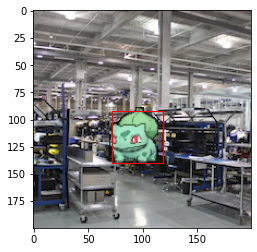

In [20]:
make_single_prediction()

In [15]:
def batch_prediction():
    #Generating batch of images
    X = np.zeros((batch_size,) + image_size, dtype=float)
    Y = np.zeros((batch_size, 8), dtype=float)
    for i in range(batch_size):
        X[i],Y[i] = get_image()
    y_pred = model.predict(X/255.)
    #Scaling back coordinates of y and y_pred into [0,dim)
    Y[:,0:4] = Y[:,0:4]*dim
    y_pred[:,0:4] = y_pred[:,0:4]*dim
    Y = np.array(np.round(Y), dtype=int)
    y_pred = np.array(np.round(y_pred), dtype=int)

    #Getting confusion matrix and filter Y and y_pred only where object was present and model predicted object too
    output_label = np.zeros(batch_size, dtype=int)
    pred_label = np.zeros(batch_size, dtype=int)
    for i in range(batch_size):
        if Y[i,7]==1:
            output_label[i] = 1+np.argmax(Y[i,4:7])
        if y_pred[i,7]==1:
            pred_label[i] = 1+np.argmax(y_pred[i,4:7])
    
    cm = confusion_matrix(output_label, pred_label)
    indexes = ((output_label==pred_label) & (output_label>0))
    Y, y_pred = Y[indexes,:4], y_pred[indexes,:4]

    #Computing intersection over union over batch of images
    height = np.maximum(np.minimum(Y[:,0]+Y[:,2],y_pred[:,0]+y_pred[:,2])-np.maximum(Y[:,0],y_pred[:,0]),0)
    width = np.maximum(np.minimum(Y[:,1]+Y[:,3],y_pred[:,1]+y_pred[:,3])-np.maximum(Y[:,1],y_pred[:,1]),0)
    common = height*width
    total = Y[:,2]*Y[:,3] + y_pred[:,2]*y_pred[:,3] - common
    iou = common/total
    return cm, iou

Confusion of Matrix on the basis of object class, 0 being not present and 1-3 for 3 classes
[[18  0  0  0]
 [ 0 18  0  0]
 [ 0  0 17  0]
 [ 0  0  0 11]]
Mean of Intersection over union over 64 batch images : 0.722
Standard deviation of Intersection over union over 64 batch images : 0.167


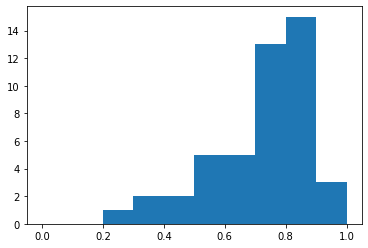

In [16]:
#Distribution of iou on single batch prediction
cm, iou = batch_prediction()
print("Confusion of Matrix on the basis of object class, 0 being not present and 1-3 for 3 classes")
print(cm)
plt.hist(iou, bins=10, range=(0,1))
print(f'Mean of Intersection over union over 64 batch images : {round(iou.mean(),3)}')
print(f'Standard deviation of Intersection over union over 64 batch images : {round(iou.std(),3)}')

[[800   0   0   0]
 [  0 799   0   0]
 [  0   0 796   0]
 [  0   0   0 805]]


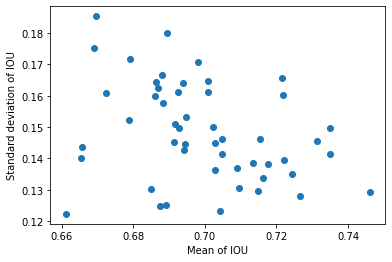

In [21]:
#Plotting how generalize our model is
iou_mean, iou_std = [],[]
cm_sum = np.zeros((4,4), dtype=int)
for i in range(num_batches):
    cm, iou = batch_prediction()
    iou_mean.append(iou.mean())
    iou_std.append(iou.std())
    cm_sum += cm
print(cm_sum)
plt.xlabel('Mean of IOU')
plt.ylabel('Standard deviation of IOU')
plt.scatter(iou_mean, iou_std)